# A/B-тест для увеличения выручки интернет-магазина

**Краткое описание проекта и постановка задачи**

Есть крупный интернет-магазина. Аналитики вместе с отделом маркетинга подготовили список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

## Изучение и предобработка данных

### Изучение данных из файлов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import datetime as dt

In [2]:
hypothesis, orders, visitors = (
    pd.read_csv('datasets/hypothesis.csv'), 
    pd.read_csv('datasets/orders.csv'), 
    pd.read_csv('datasets/visitors.csv') 
)

In [3]:
# функция для вывода общей информации, пропусков и явных дубликатов по датасэтам
# а также функция для приведения названий столбцов к нижнему регистру

def hello(dataset):
    dataset.columns = dataset.columns.str.lower()
    return (
    dataset.info(),
    display(dataset.head()),
    display('Пропуски', dataset.isna().sum(),
    display('Дубликаты',  dataset.duplicated().sum()))
)

In [4]:
hello(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


'Дубликаты'

0

'Пропуски'

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

None

(None, None, None)

In [5]:
hello(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


'Дубликаты'

0

'Пропуски'

transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64

None

(None, None, None)

In [6]:
hello(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


'Дубликаты'

0

'Пропуски'

date        0
group       0
visitors    0
dtype: int64

None

(None, None, None)

### Предобработка данных

In [7]:
# переназовем нужные столбцы датафрейма orders в соответствии с правилами змеиного регистра

orders = orders.rename(columns={'transactionid': 'transaction_id', 'visitorid': 'visitor_id'})

In [8]:
# приведение типа данных столбцов, к нужному формату

orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

### Вывод:
1) По итогам изучения данных: пропусков и дубликатов не выявлено

2) Данные предобработаны следующим образом:

- названия всех столбцов приведены к змеиному регистру;
- столбцы с датами приведены к типу datetime

## Приоритизация гипотез.

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

In [9]:
# выведем датафрейм hypothesis с заменой индексов гипотез (от 1 до 9)

pd.set_option('display.max_colwidth', None)
a = list(range(1, 10))
hypothesis.index = a
hypothesis

,hypothesis,reach,impact,confidence,efforts
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
2,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
3,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
4,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
5,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
7,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
9,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [10]:
# применим ICE для приоритизации гипотез
# создадим отдельную переменную, отсортируем по убыванию, сделаем новый столбец с индексом гипотез по ICE

hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 1)
ICE_rating = hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)
ICE_rating['ICE_index'] = a
ICE_rating

,hypothesis,ICE,ICE_index
9,"Запустить акцию, дающую скидку на товар в день рождения",16.2,1
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3,2
8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,3
7,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0,4
3,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0,5
2,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,6
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3,7
4,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1,8
5,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,9


In [11]:
# применим RICE для приоритизации гипотез
# создадим отдельную переменную, отсортируем по убыванию, сделаем новый столбец с индексом гипотез по ICE

hypothesis['RICE'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 1)
RICE_rating = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
RICE_rating['RICE_index'] = a
RICE_rating

,hypothesis,RICE,RICE_index
8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,1
3,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,2
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,3
7,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,4
9,"Запустить акцию, дающую скидку на товар в день рождения",16.2,5
4,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,6
2,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,7
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,8
5,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,9


In [12]:
# объединим переменные в 1 таблицу, чтобы было легко сравнить индексы гипотез по ICE и RICE

ICE_RICE = ICE_rating.merge(RICE_rating, on = ['hypothesis']).set_index(ICE_rating.index)
ICE_RICE

,hypothesis,ICE,ICE_index,RICE,RICE_index
9,"Запустить акцию, дающую скидку на товар в день рождения",16.2,1,16.2,5
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3,2,40.0,3
8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,3,112.0,1
7,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0,4,40.0,4
3,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0,5,56.0,2
2,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,6,4.0,7
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3,7,4.0,8
4,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1,8,9.0,6
5,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,9,3.0,9


### Вывод:
- ***топ-5 гипотез по методам приоритизации гипотез ICE и RICE совпадает***, отличается только место в рейтинге за счет влияния параметра Reach
- так гипотеза-лидер по методу приоритизации гипотез ICE (№9) имеет по парметру Reach всего 1 балл, а гипотеза №8 - 112 баллов, поэтому при применении метода RICE и происходит смена лидера с №9 на №8
- **самыми приоритетными по обоим методам являются:**
  - гипотеза №1 **"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"** - 2-е место по ICE и 3-е по RICE
  - гипотеза №8 **"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"** - 3-е место по ICE и 1-е по RICE)

## Анализ A/B-теста

### Проверка данных на наличие пользователей, попавших в обе группы теста одновременно

In [13]:
# проверим, есть ли пользователи, вошедшие в группу А и В одновременно
# для этого сгруппируем orders по visitor_id и посчитаем, в какое количество групп входит каждый пользователь
# оставим только тех пользователей, которые входят в более, чем 1 группу

duplicates_A_B = (
    orders.groupby(by='visitor_id').agg({'group': 'nunique'})
    .rename(columns ={'group': 'group_count'}) \
    .query('group_count > 1')
)

# посчитаем, сколько в данных таких пользователей

print('Количество пользователей, попавших в обе группы теста:', len(duplicates_A_B))
print(
      'Доля таких пользователей в общем количестве пользователей: ','{:.0%}'.format(
      len(duplicates_A_B) / orders['visitor_id'].nunique())
)

Количество пользователей, попавших в обе группы теста: 58
Доля таких пользователей в общем количестве пользователей:  6%


In [14]:
# отфильтруем датасэт orders от пользователей, попавших в обе группы одновременно
# с помощью lambda функции, которая пройдется по столбцу visitor_id
# и проверит каждый элемент столбца x на вхождение в список пользователей из duplicates_A_B
# для проверки внесенных изменений посчитаем количество уникальных пользователей до и после изменений

print('Количество уникальных пользователей до изменений: ', orders['visitor_id'].nunique())

orders = orders[~orders['visitor_id'].map(lambda x: x in duplicates_A_B.index)]

print('Количество уникальных пользователей после удаления части пользователей: ', orders['visitor_id'].nunique())

Количество уникальных пользователей до изменений:  1031
Количество уникальных пользователей после удаления части пользователей:  973


#### Предварительный вывод:
- В данном тесте количество пользователей, попавших в обе группы одновременно, составило порядка 6%
- Для корректной оценки результатов теста такие пользователи были удалены из общего числа пользователей

### График кумулятивной выручки по группам

In [15]:
# создаем массив уникальных пар значений дат и групп теста

datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о транзакциях 

ordersAggregated = (
    datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

# получаем агрегированные кумулятивные по дням данные о посетителях

visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [16]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

In [17]:
# функция для вывода графиков1

def graph1(x, y1, y2, title, ylabel, ylim):
    plt.figure(figsize=(15, 8))
    plt.plot(x, y1, label='A')
    plt.plot(x, y2, label='B')
    plt.legend(fontsize=12)
    plt.xlabel('дата', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=20)
    plt.ylim(ylim)
    return plt.show()  

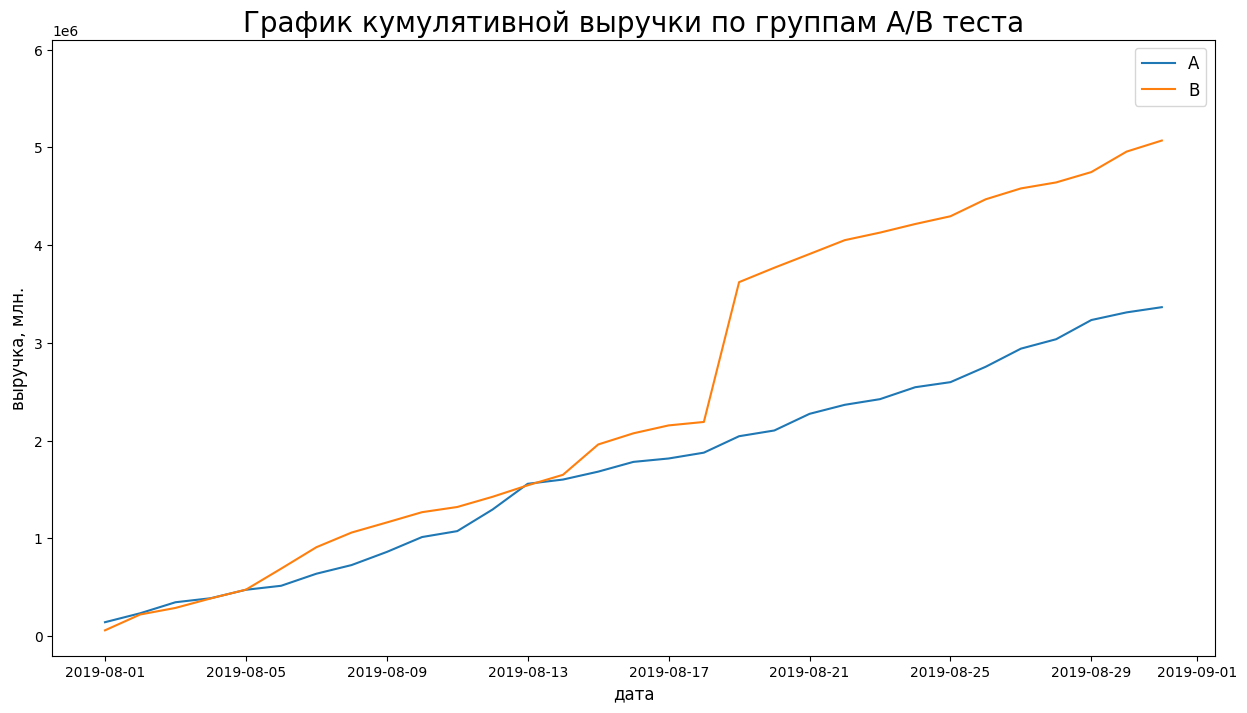

In [18]:
# построим графики выручки группы А и группы B

x = cumulativeRevenueA['date']
y1 = cumulativeRevenueA['revenue']
y2 = cumulativeRevenueB['revenue']
title = 'График кумулятивной выручки по группам A/B теста'
ylabel = 'выручка, млн.'
ylim = (-200000, 6100000)
graph1(x, y1, y2, title, ylabel, ylim)

#### Предварительный вывод:
- ***Выручка*** по обеим группам более-менее равномерно ***увеличивается*** в течение всего теста
- Однако на графиках в нескольких местах набюдаются пики, что может говорить ***о наличии выбросов***, которые нужно будет далее сгладить для получения адекватных результатов теста

### График кумулятивного среднего чека по группам

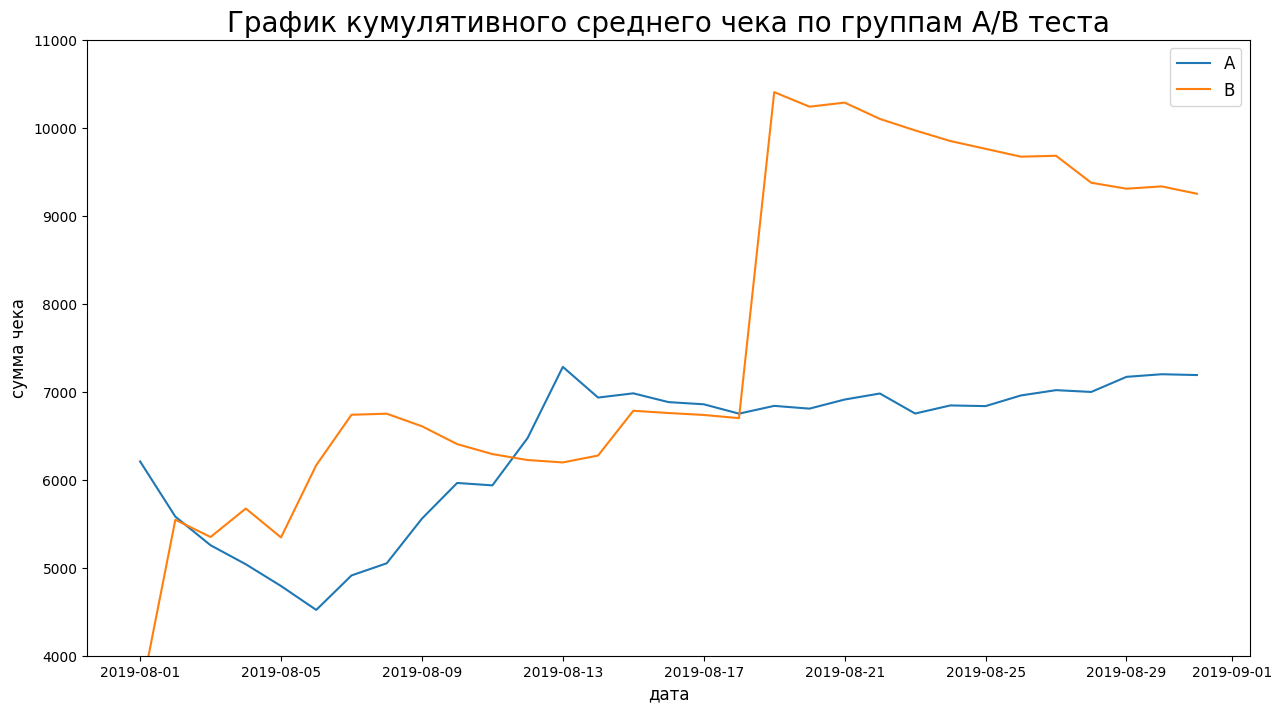

In [19]:
# построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

x = cumulativeRevenueA['date']
y1 = cumulativeRevenueA['revenue']/cumulativeRevenueA['orders']
y2 = cumulativeRevenueB['revenue']/cumulativeRevenueB['orders']
title = 'График кумулятивного среднего чека по группам A/B теста'
ylabel = 'сумма чека'
ylim = (4000, 11000)
graph1(x, y1, y2, title, ylabel, ylim)

#### Предварительный вывод:

Графики среднего чека по группам теста ведут себя очень по-разному:
- ***по группе А наблюдается некоторая стабилизация чека*** ближе к концу теста выше 7000
- ***по группе В*** наблюдается скачкобразный рост с резким подъемом суммы чека во второй половине теста выше 10000, а затем плавным снижением; здесь точно ***можно констатировать наличие выбросов*** и нельзя говорить ни о какой стаблилизации, для начала надо посмотреть на очищенные данные

### График относительного изменения кумулятивного среднего чека группы B к группе A

In [20]:
# функция для вывода графиков2

def graph2(x, y, y1, y2, title, ylabel, ylim):
    plt.figure(figsize=(15, 8))
    plt.plot(x, y)
    plt.title('График относительного изменения ' + title, fontsize=20)
    plt.axhline(y1, color='grey', linestyle='--')
    plt.axhline(y2, color='black', linestyle='--')
    plt.xlabel('дата', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.ylim(ylim)
    return plt.show()

In [21]:
# собираем данные в одном датафрейме

mergedCumulativeRevenue = (
    cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

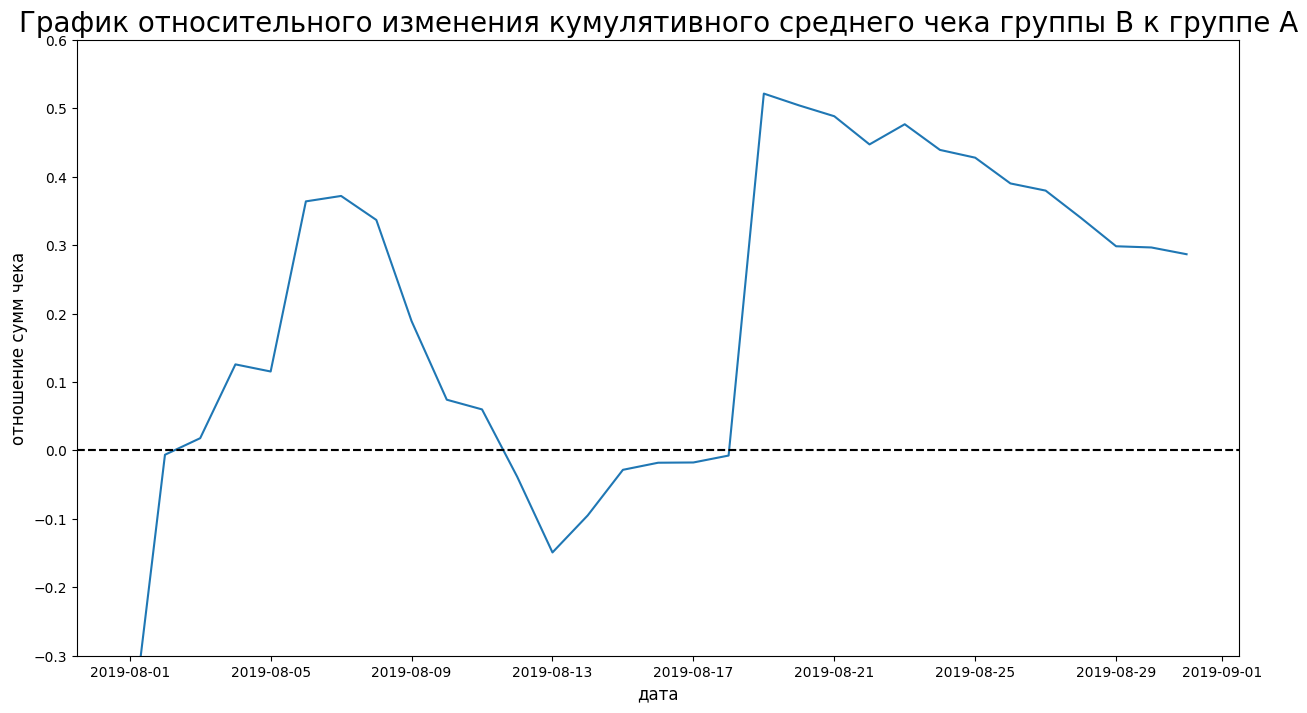

In [22]:
# cтроим график отношения кумулятивных средних чеков

x = mergedCumulativeRevenue['date']
y = (
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
    (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1
)
y1 = 0
y2 = 0
title = 'кумулятивного среднего чека группы B к группе A'
ylabel = 'отношение сумм чека'
ylim = (-0.3, 0.6)
graph2(x, y, y1, y2, title, ylabel, ylim)

#### Предварительный вывод:

- График относительного изменения кумулятивного среднего чека B к А имеет несколько пиков и крутой провал за рассматриваемый период
- Это опять же подтверждает ***наличие выбросов***

### График кумулятивной конверсии по группам

In [23]:
# считаем кумулятивную конверсию

cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A и B

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

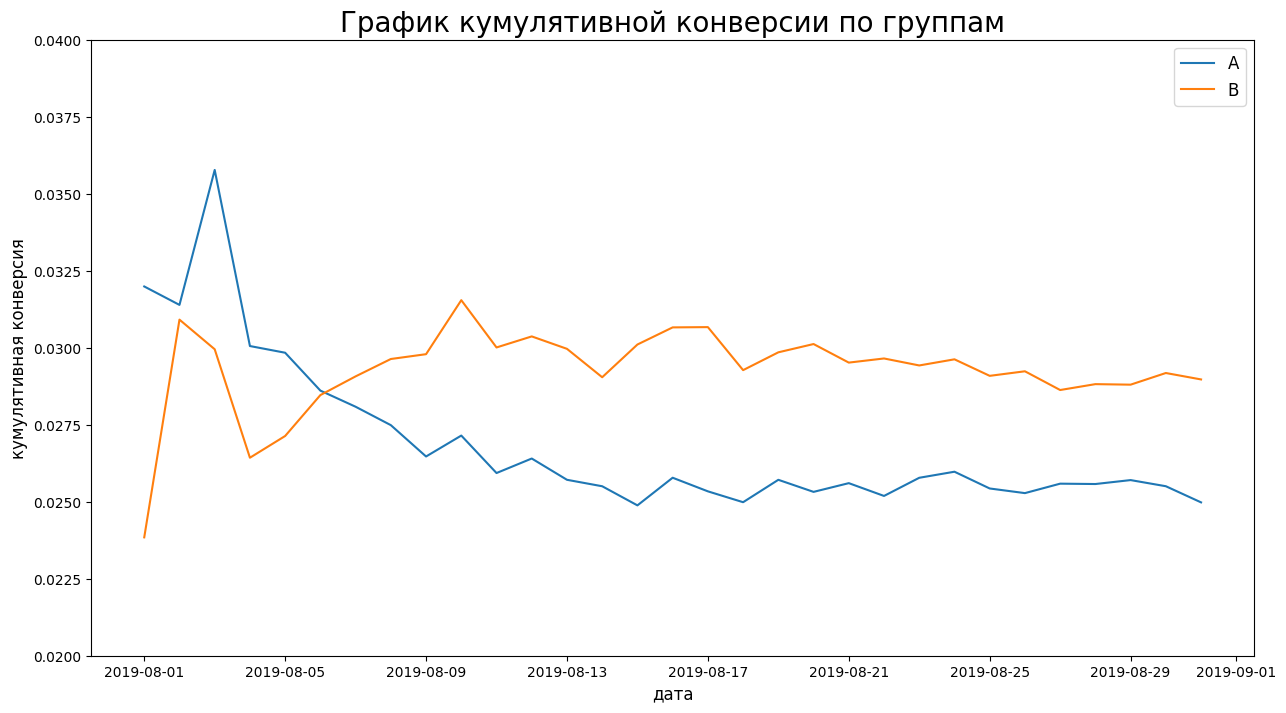

In [24]:
# строим графики кумулятивной конверсии по группам

x = cumulativeDataA['date']
y1 = cumulativeDataA['conversion']
y2 = cumulativeDataB['conversion']
title = 'График кумулятивной конверсии по группам'
ylabel = 'кумулятивная конверсия'
ylim = (0.02, 0.04)
graph1(x, y1, y2, title, ylabel, ylim)

#### Предварительный вывод:

- Графики кумулятивной конверсии по обеим группам зафиксировались
- ***Конверсия группы В стабильно лучше группы А***

### График относительного изменения кумулятивной конверсии группы B к группе A

In [25]:
# объединим датасэты с кумулятивной конверсией в один

mergedCumulativeConversions = (
    cumulativeDataA[['date','conversion']]
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

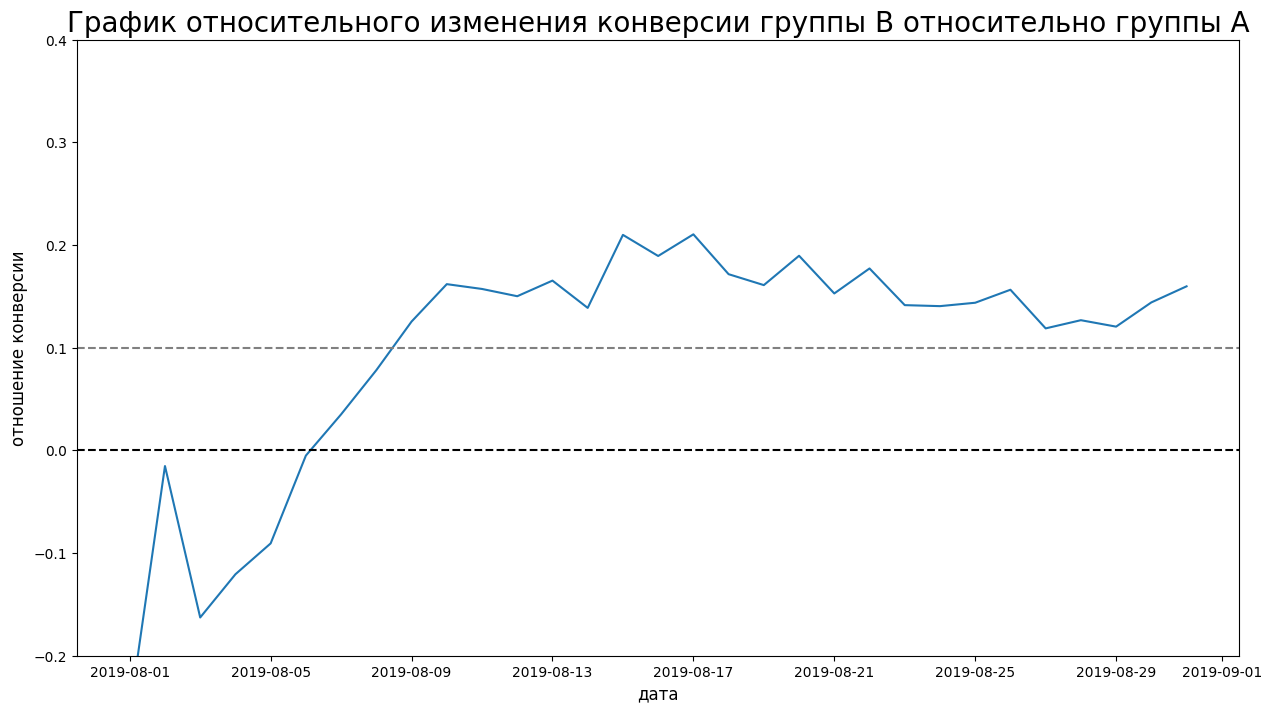

In [26]:
# строим график отношения кумулятивных средних чеков

x = mergedCumulativeConversions['date']
y =  mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1
y1 = 0.1
y2 = 0
title = 'конверсии группы B относительно группы A'
ylabel = 'отношение конверсии'
ylim = (-0.2, 0.4)
graph2(x, y, y1, y2, title, ylabel, ylim)

#### Предварительный вывод:

- ***Конверсия группы B*** относительно конверсии группы А в начале теста сильно колебалась, но затем стала ***стабильно лучше на 10-15%***
- Но в целом ***отношение конверсии более-менее установилось***
- Но на графике все же видны аномалии и выбросы,    которые нужно выявить статистически и в дальнейшем скорректировать

### Точечный график количества заказов по пользователям. 95-й и 99-й перцентили количества заказов на пользователя

In [27]:
# подсчитаем количество заказов по пользователям

ordersByUsers = (
     orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['user_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


In [28]:
#функция для создания точечного графика

def graph3(column, title, ylabel):
    x_values = pd.Series(range(0, len(column)))
    plt.figure(figsize=(15, 8))
    plt.scatter(x_values, column)
    plt.title('Точечный график ' + title, fontsize=20)
    plt.xlabel('частотность заказов', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    return plt.show()

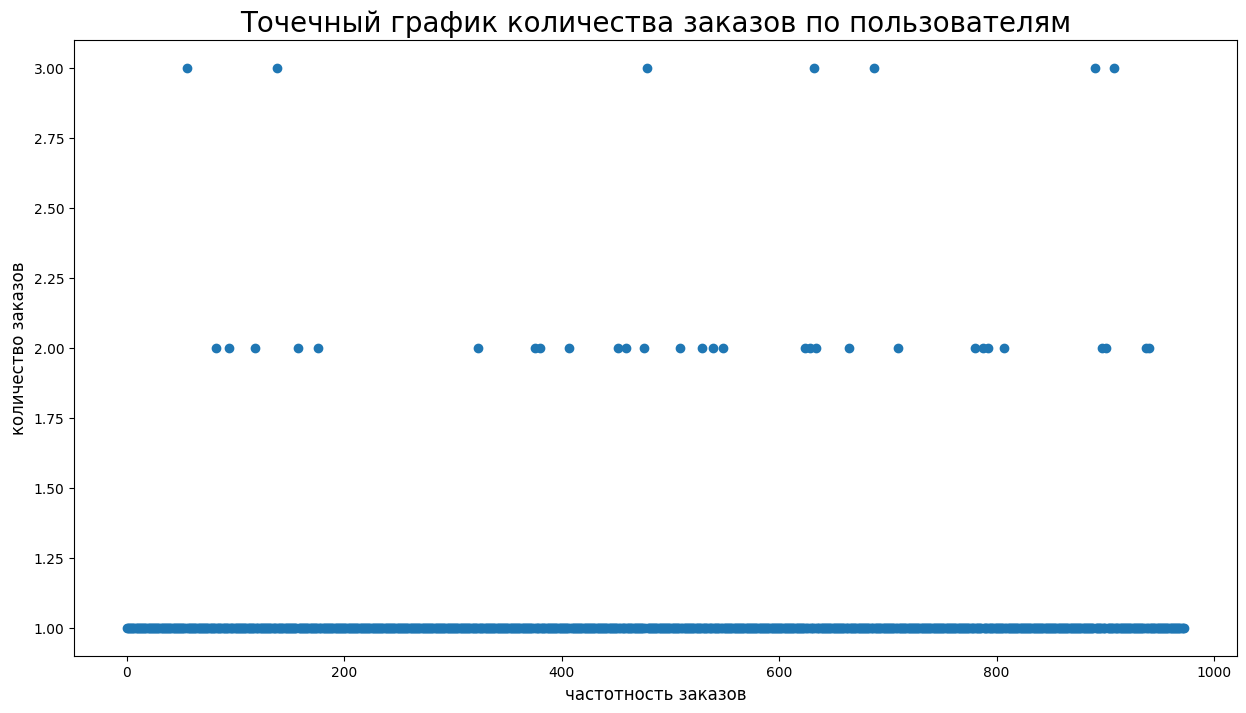

In [29]:
# строим точечный график количества заказов

column = ordersByUsers['orders']
title = 'количества заказов по пользователям'
ylabel = 'количество заказов'
graph3(column, title, ylabel)

- На графике видны, скорее всего, аномалии по пользователям с количествоми заказом свыше 2
- Для определения границы отсечения выбросов посчитаем 95-й и 99-й перцентили по корличеству заказов

In [30]:
# считаем 95-й и 99-й перцентили по количеству заказов на 1 пользователя 

np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

#### Предварительный вывод:

- Не более 5% пользователей совершают более 1 заказа и не более 1%  - 2 и более
- Для получения более корректных результатов теста ***необходимо будет очистить сырые данные от пользователей с количеством заказов более 2*** (1% от пользователей)

### Точечный график стоимостей заказов. 95-й и 99-й перцентили стоимости заказов

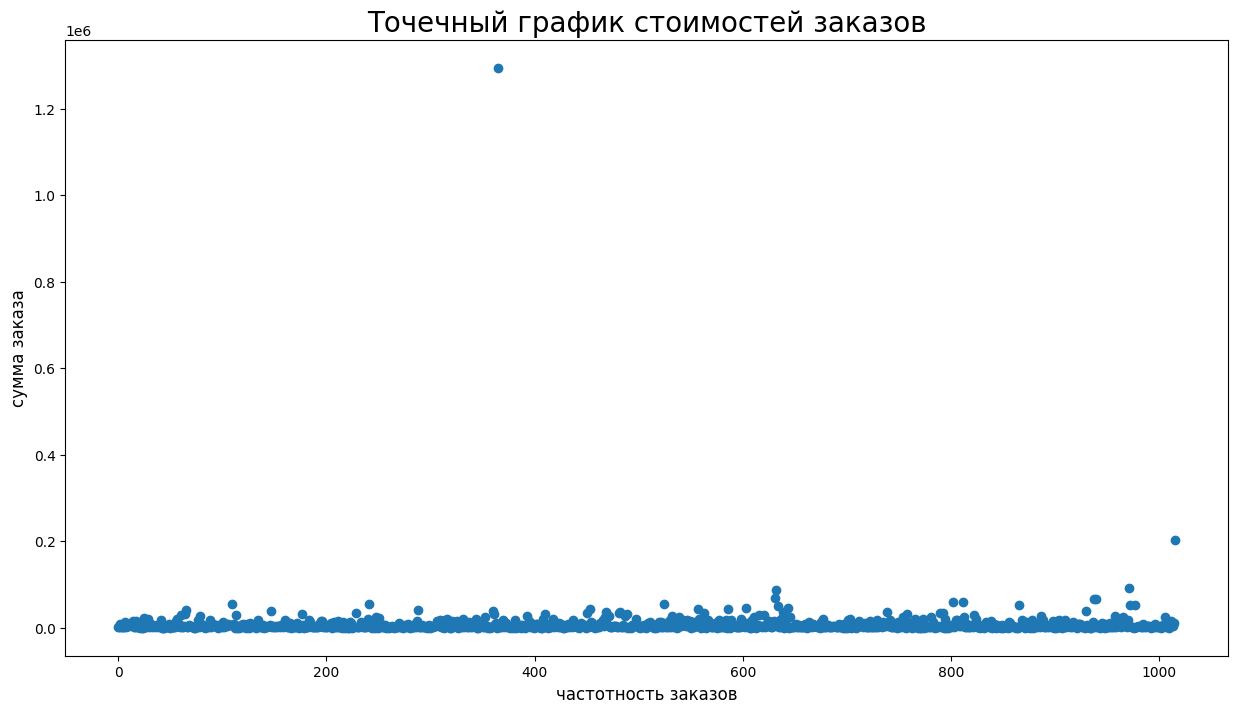

In [31]:
# строим точечный график стоимостей заказов

column = orders['revenue']
title = 'стоимостей заказов'
ylabel = 'сумма заказа'
graph3(column, title, ylabel)

- На графике видны, скорее всего, выбросы с суммой заказа примерно выше 50 000
- Для определения границы отсечения выбросов посчитаем 95-й и 99-й перцентили по стоимости заказов

In [32]:
# считаем 95-й и 99-й перцентили по стоимости заказов 

np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

#### Предварительный вывод:

- Не более 5% заказов дороже 27 000 и не более 1% дороже 54 000
- Для получения более корректных результатов теста ***необходимо будет очистить сырые данные от заказов выше 54 000*** (1% от всех заказов) 

### Расчет статистической значимости различий в конверсии между группами по «сырым» данным

- Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей
- Сформулируем гипотезы:
  - ***Нулевая: различий в конверсии между группами нет***
  - ***Альтернативная: различия в конверсии между группами есть***

In [33]:
# подготовим данные для расчета
# датафрейм с данными о пользователях по датам по группе А

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']


# датафрейм с кумулятивным количеством пользователей и максимальной датой по группе В

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# датафрейм с данными о пользователях по датам по группе А

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# датафрейм с кумулятивным количеством пользователей и максимальной датой по группе В

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


# датафрейм с информацией о количестве и сумме заказов по дням по группе А

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# датафрейм с кумулятивной информацией о количестве и сумме заказов по дням по группе А

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# датафрейм с информацией о количестве и сумме заказов по дням по группе В

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# датафрейм с кумулятивной информацией о количестве и сумме заказов по дням по группе В

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# объединение 8 созданных датафреймов в единый

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [34]:
# датафрейм с информацией по количеству заказов по пользователям из группы А 

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['user_id', 'orders']

# датафрейм с информацией по количеству заказов по пользователям из группы В 

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['user_id', 'orders']

# выборка по группе А, где каждый элемент — число заказов определённого пользователя, в том числе ноль

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# выборка по группе В, где каждый элемент — число заказов определённого пользователя, в том числе ноль

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

alpha = 0.05 # критический уровень статистической значимости

# проверка данных тестом Уилкоксона-Манна-Уитни

results = st.mannwhitneyu(sampleA, sampleB).pvalue

print('p-значение: ', '{0:.3f}'.format(results))

if results < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

# выводим изменение конверсий по группам, рассчитанное, как среднее по всем заказам (в том числе и нулевым) по каждой группе

print('изменение конверсии выборки В по отношению к выборке А: ','{0:.0%}'.format(sampleB.mean() / sampleA.mean() - 1))

p-значение:  0.011
Отвергаем нулевую гипотезу: разница статистически значима
изменение конверсии выборки В по отношению к выборке А:  16%


#### Предварительный вывод:

- Поскольку p-значение меньше критического уровеня статистической значимости, то отвергаем нулевую гипотезу и получаем, что ***статистическая разница в конверсии между группами по сырым данным значима***
- ***Конверсия по группе В выше конверсии по группе А на 16%***

### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

- Посчитаем статистическую значимость различий в среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей
- Сформулируем гипотезы:
  - ***Нулевая: различий в среднем чеке между группами нет***
  - ***Альтернативная: различия в среднем чеке между группами есть***

In [35]:
# проверка данных тестом Уилкоксона-Манна-Уитни

alpha = 0.05

results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue']).pvalue
print('p-значение: ', '{0:.3f}'.format(results))

if results < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

check_diff = orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1
print('изменение среднего чека выборки В по отнощению к выборке А: ', '{0:.0%}'.format(check_diff)) 

p-значение:  0.829
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
изменение среднего чека выборки В по отнощению к выборке А:  29%


#### Предварительный вывод:

- Поскольку p-значение больше критического уровеня статистической значимости, то не отвергаем нулевую гипотезу и получаем, что ***статистическая разница в среднем чеке между группами по сырым данным не значима***
- ***Но при этом средний чек по группе В выше чека по группе А на 29%***
- Необходимо проверить статистическую значимость на очищенных данных

### Расчет статистической значимости различий в конверсии между группами по «очищенным» данным

- Напомним, что 99-ый перцентиль:
 - по количеству заказов на 1 пользователя - 2
 - по стоимости заказов - 54 000 
- Примем за аномальных пользователей тех, кто совершил более 2 заказов (уберем менее 1% пользователей) или совершил заказ дороже 55 000 рублей (менее 1% пользователей)

In [36]:
# датафрейм со срезом заказов более 2 на 1 пользователя

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['user_id'],
    ],
    axis=0,
)

# датафрейм со срезом суммы заказов более 55 000

usersWithExpensiveOrders = orders[orders['revenue'] > 55000]['visitor_id']

# объединение 2-х срезов в единый датафрейм

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

display(abnormalUsers.head())
abnormalUsers.shape[0]

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64

16

Аномальных пользователей - всего 16

In [37]:
# подговтоим очищенные выборки количества заказов по пользователям по группам А и В

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

- Также, как и в прошлый раз сформулируем гипотезы:
  - ***Нулевая: различий в конверсии между группами нет***
  - ***Альтернативная: различия в конверсии между группами есть***

In [38]:
# проверка данных тестом Уилкоксона-Манна-Уитни

alpha = 0.05

results = st.mannwhitneyu(sampleAFiltered, sampleBFiltered).pvalue
print('p-значение: ', '{0:.3f}'.format(results))

if results < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

print('изменение конверсии выборки В по отношению к выборке А: ', '{0:.0%}' \
      .format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-значение:  0.007
Отвергаем нулевую гипотезу: разница статистически значима
изменение конверсии выборки В по отношению к выборке А:  19%


#### Предварительный вывод:

- Поскольку p-значение меньше критического уровня статистической значимости, то отвергаем нулевую гипотезу и получаем, что ***статистическая разница в конверсии между группами по очищенным данным значима***
- ***Конверсия по группе В выше конверсии по группе А на 19%***
- Т.о. ***по конверсии после очистки данных существенных изменений не произошло***: различия в конверсии, как были, так и остались, изменение конверсии выборки В по отношению к выборке А выросло на 3% (16% по сырым данным)

### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

- Также, как и в прошлый раз сформулируем гипотезы:
  - ***Нулевая: различий в среднем чеке между группами нет***
  - ***Альтернативная: различия в среднем чеке между группами есть***

In [39]:
# проверка данных тестом Уилкоксона-Манна-Уитни

alpha = 0.05

checkA = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormalUsers)),)]['revenue']
checkB = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormalUsers)),)]['revenue']

results = st.mannwhitneyu(checkA, checkB).pvalue \

print('p-значение: ', '{0:.3f}'.format(results))

if results < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print('изменение среднего чека выборки В по отнощению к выборке А: ', '{0:.0%}'.format(checkB.mean() / checkA.mean() - 1)) 

p-значение:  0.788
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
изменение среднего чека выборки В по отнощению к выборке А:  -3%


#### Предварительный вывод:

- Поскольку p-значение больше критического уровеня статистической значимости, то не отвергаем нулевую гипотезу и получаем, что ***статистическая разница в среднем чеке между группами по очищенным данным не значима***
- ***Но при этом по очищенным данным средний чек по группе В стал ниже чека по группе А на 3% (против +29% по сырым данным)***
- Т.о. ***несоответствие***, которое наблюдалось между результатом теста и расчетным изменением среднего чека одной группы к другой, ***устранилось после очистки данных от выбросов*** в виде слишком дорогих заказов

### Вывод по результатам теста

Зафиксируем основные выводы, сделанные на основании исследования конверсии пользователей и среднего чека заказов по группам А и В:

1) **Конверсия:**
- график относительной конверсии по группам показывает, что конверсия группы В стабильно лучше группы А
- это подтверждается статистически: и по сырым, и по очищенным данным есть статистическая разница в конверсиях по группам - ***конверсия по группе В выше конверсии по группе А на 19%*** (данные без выбросов)

2) **Средний чек:**
- график относительного изменения кумулятивного среднего чека B к А имеет не информативен из-за выбросов
- ***разница в среднем чеке по группам не подтверждается статистически***: после очистки данных от выбросов средний чек по группе В стал ниже чека по группе А на 3% (против +29% по сырым данным)

**Вывод по результатам теста:**</span>

***Тест необходимо остановить и зафиксировать победу группы В***: несмотря на то, что средний чек по этой группе практически не изменился к группе А, конверсия пользователей существенно выросла (+19% по очищенным данным) - это очень хороший результат

## Общий вывод

**1. Приоритизация гипотез:**

- ***топ-5 гипотез по методам приоритизации гипотез ICE и RICE совпадает***, отличается только место в рейтинге за счет влияния параметра Reach
- **самыми приоритетными по обоим методам являются:**
  - гипотеза №1 **"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"** - 2-е место по ICE и 3-е по RICE
  - гипотеза №8 **"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"** - 3-е место по ICE и 1-е по RICE)

**2. Анализ A/B-теста:**

1) **Выручка:**
- по обеим группам более-менее равномерно ***увеличивается*** в течение всего теста

2) **Средний чек:**
- ***по группе А наблюдается некоторая стабилизация чека*** ближе к концу теста выше 7 000
- ***по группе В*** наблюдается скачкобразный рост с резким подъемом суммы чека во второй половине теста выше 10 000, а затем сменяется плавным снижением; нельзя говорить ни о какой стаблилизации
- график относительного изменения кумулятивного среднего чека группы B к А имеет также несколько пиков и крутой провал за рассматриваемый период

3) **Конверсия:**
- графики кумулятивной конверсии по обеим группам зафиксировались: ***конверсия группы В стабильно лучше группы А***
- ***конверсия группы B*** относительно конверсии группы А в начале теста сильно колебалась, но затем стала ***выше на 10-15%***

4) **Выбросы:**
- ***видны на графиках*** кумулятивной выручки, кумулятивного среднего чека по группам, относительного изменения кумулятивного среднего чека группы B к А, относительного изменения конверсии группы В к А, точечных графиках количества заказов по пользователям и стоимости заказов
- ***оцениваются на основе 95-ого и 99-ого перцентиля*** по количеству заказов по пользователям и стоимости заказов: не более 5% пользователей совершают более 1 заказа и не более 1%  - 2 и более; не более 5% заказов дороже 27 000 и не более 1% дороже 54 000
- ***корректируются путем среза данных***: отсеиваются пользователи с количеством заказов свыше 2-х (99-ый перцентиль), а также заказы, стоимость которых превышает 55 000 (экспертная оценка на основе 99-ого перцентиля)

5) **Статистическая значимость разницы конверсий по группам:**
- ***подтверждается*** тестом Уилкоксона-Манна-Уитни как на сырых, так и на очищенных данных
- ***конверсия по группе В выше конверсии по группе А на 16% по сырым данным и на 19% по очищенным данным***

6) **Статистическая значимость разницы средних чеков по группам:**
- ***не подтверждается*** тестом Уилкоксона-Манна-Уитни как на сырых, так и на очищенных данных
- средний чек по сырым данным по группе В превышал чек по группе А на 29%, но ***после очистки данных разница изменилась до 3% в пользу группы А***

7) **Вывод по результатам теста:**
- ***тест необходимо остановить и зафиксировать победу группы В***: несмотря на то, что средний чек по этой группе практически не изменился к группе А, ***конверсия пользователей существенно выросла (+19% по очищенным данным) - это очень хороший результат***